In [12]:
import os
import seaborn as sns
path = '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Analysis/Figures'
import sys
sys.path.insert(1, '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Data Collection')
from configs import *
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.axisartist.axislines import SubplotZero
from pylab import text
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "lualatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from sqlalchemy import create_engine

engine = create_engine('mysql+mysqlconnector://'+user+':'+passwd+'@'+ip+':3306/'+schema1)


In [2]:
stmt = 'SELECT DATE_FORMAT(date, \'%Y-%m\') as date, COUNT(1) AS tweets FROM social.machine_learning_only group by DATE_FORMAT(date, \'%Y-%m\') ORDER BY DATE_FORMAT(date, \'%Y-%m\') ASC' 
stmt2 = 'SELECT DATE_FORMAT(date, \'%Y-%m\') as date, COUNT(1) AS tweets FROM social.machine_learning group by DATE_FORMAT(date, \'%Y-%m\') ORDER BY DATE_FORMAT(date, \'%Y-%m\') ASC' 
df = pd.read_sql(stmt, con=engine)
df2 = pd.read_sql(stmt2, con=engine)

# Machine Learning

In [3]:
#ML
year = ['2010-01-01', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31', '2021-12-31']
papers = [6151, 6572, 7207, 7937, 9308, 11141, 13609, 17449, 23410, 35663, 59378, 70504, 90290]

df['date']  = pd.to_datetime(df['date'])
df2['date']  = pd.to_datetime(df['date'])
year = pd.to_datetime(year)

In [4]:
#ML plot
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Time')
plt.ylabel('Number of Records')
plt.plot(df['date'], df['tweets'], c = '#E31B23', linewidth = 1, label='Tweets')
# plt.plot(df2['date'], df2['tweets'], c = 'black', linewidth = 1, label='Unfiltered Tweets')
plt.plot(year, papers, c = '#339898', linewidth = 1, label='Academic Publications')
plt.legend()
plt.savefig(os.path.join(path, 'ml_data.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [5]:
#ML plot
stmt = 'SELECT YEAR(date) as date, COUNT(1) AS tweets FROM social.machine_learning_only group by YEAR(date) ORDER BY date ASC'

df = pd.read_sql(stmt, con=engine)

year = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
papers = [6151, 6572, 7207, 7937, 9308, 11141, 13609, 17449, 23410, 35663, 59378, 70504, 90290]
df['tweets_pct'] = 100*df.tweets.pct_change()
papers_pct = 100*pd.Series(papers).pct_change()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Time')
plt.ylabel('Percentage Change')
plt.plot(df['date'], df['tweets_pct'], c = '#E31B23', linewidth = 1, label='Tweets')
# plt.plot(df2['date'], df2['tweets'], c = 'black', linewidth = 1, label='Unfiltered Tweets')
plt.plot(year, papers_pct, c = '#339898', linewidth = 1, label='Academic Publications')
plt.legend()
plt.savefig(os.path.join(path, 'ml_data_pct.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [6]:
degree = 2
y = np.array(df2['tweets'].to_list())
X = np.array(df2['date'].to_list())
date_index = []
idx = 0
for i in X:
    date_index.append(idx)
    idx += 1

z = np.polyfit(date_index, y, degree)
f = np.poly1d(z)

In [7]:
df_trend = pd.DataFrame(columns=['X', 'y','d'])
df_trend['X'] = date_index
df_trend['y'] = y
df_trend['d'] = X


z = np.polyfit(df_trend.X, df_trend.y, degree)
model = np.poly1d(z)
results = smf.ols(formula='y ~ model(X)', data=df_trend).fit()

# results.summary()

In [8]:
column = df_trend["y"]
max_index = column.idxmax()
df_trend_1 = df_trend.head(max_index)
tail_index =  len(df_trend.index) - max_index
df_trend_2 = df_trend.tail(tail_index)

In [9]:
#first half
df_trend = df_trend_1
z = np.polyfit(df_trend.X, df_trend.y, degree)
model = np.poly1d(z)
results = smf.ols(formula='y ~ model(X)', data=df_trend).fit()
# print(results.summary().as_latex())

In [10]:
#first half plot
ax = plt.gca()
plt.xlabel('Time')
plt.ylabel('Number of Records')
plt.plot(df_trend.d, df_trend.y, label='Unfiltered Tweets', c = 'black')
plt.plot(df_trend.d, model(df_trend.X), "--", c = '#E31B23', label = 'Exponential Trend Function')
plt.xticks(rotation = 45)
# myFmt = mdates.DateFormatter('%Y')
# ax.xaxis.set_major_formatter(myFmt)
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.savefig(os.path.join(path, 'ml_trend_1a.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()


In [11]:
#second half
df_trend = df_trend_2
z = np.polyfit(df_trend.X, df_trend.y, degree)
model = np.poly1d(z)
results = smf.ols(formula='y ~ model(X)', data=df_trend).fit()
# print(results.summary().as_latex())

In [12]:
#second half plot
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Time')
plt.ylabel('Number of Records')
plt.plot(df_trend.d, df_trend.y, label='Unfiltered Tweets', c = 'black')
plt.plot(df_trend.d, model(df_trend.X), "--", c = '#E31B23', label = 'Exponential Trend Function')
plt.xticks(rotation = 45)
pos = ['2018-01-01','2019-01-01','2020-01-01','2021-01-01','2022-01-01']
l = [2018,2019,2020,2021,2022]
ax.set(xticks=pos, xticklabels=l)
plt.legend()
plt.savefig(os.path.join(path, 'ml_trend_2a.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

## Filtered tweets

In [13]:
degree = 2
y = np.array(df['tweets'].to_list())
X = np.array(df['date'].to_list())
date_index = []
idx = 0
for i in X:
    date_index.append(idx)
    idx += 1

z = np.polyfit(date_index, y, degree)
f = np.poly1d(z)

In [14]:
df_trend = pd.DataFrame(columns=['X', 'y','d'])
df_trend['X'] = date_index
df_trend['y'] = y
df_trend['d'] = X


z = np.polyfit(df_trend.X, df_trend.y, degree)
model = np.poly1d(z)
results = smf.ols(formula='y ~ model(X)', data=df_trend).fit()

# results.summary()

In [15]:
column = df_trend["y"]
max_index = column.idxmax()
df_trend_1 = df_trend.head(max_index)
tail_index =  len(df_trend.index) - max_index
df_trend_2 = df_trend.tail(tail_index)

In [16]:
#first half
df_trend = df_trend_1
z = np.polyfit(df_trend.X, df_trend.y, degree)
model = np.poly1d(z)
results = smf.ols(formula='y ~ model(X)', data=df_trend).fit()
# print(results.summary().as_latex())

In [17]:
#first half plot
ax = plt.gca()
plt.xlabel('Time')
plt.ylabel('Number of Records')
plt.plot(df_trend.d, df_trend.y, label='Filtered Tweets', c = 'black')
plt.plot(df_trend.d, model(df_trend.X), "--", c = '#E31B23', label = 'Exponential Trend Function')
plt.xticks(rotation = 45)

plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.savefig(os.path.join(path, 'ml_trend_1b.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [18]:
#second half
df_trend = df_trend_2
z = np.polyfit(df_trend.X, df_trend.y, degree)
model = np.poly1d(z)
results = smf.ols(formula='y ~ model(X)', data=df_trend).fit()
# print(results.summary().as_latex())

In [19]:
#second half plot
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Time')
plt.ylabel('Number of Records')
plt.plot(df_trend.d, df_trend.y, label='Filtered Tweets', c = 'black')
plt.plot(df_trend.d, model(df_trend.X), "--", c = '#E31B23', label = 'Exponential Trend Function')
plt.xticks(rotation = 45)
pos = ['2018-01-01','2019-01-01','2020-01-01','2021-01-01','2022-01-01']
l = [2018,2019,2020,2021,2022]
ax.set(xticks=pos, xticklabels=l)
plt.legend()
plt.savefig(os.path.join(path, 'ml_trend_2b.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

ConversionError: Failed to convert value(s) to axis units: ['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']

# Twitter Users

In [20]:
df = pd.read_csv('/Users/connormcdonald/Desktop/Masters/MIT807/Data/TwitterUsers.csv')
df['period']  = pd.to_datetime(df['period'])

In [21]:
df['mau_pct'] = 100*df.mau.pct_change()
df['dau_pct'] = 100*df.dau.pct_change()

In [22]:
comb = []
for i in range(len(df.index)):
    
    if pd.isna(df.mau_pct[i]) == True  and pd.isna(df.dau_pct[i]) == True:
        comb.append(df.mau_pct[i])
        # print(f'first if satisfied: {i}\n')

    if pd.isna(df.mau_pct[i]) == False  and pd.isna(df.dau_pct[i]) == True:
        comb.append(df.mau_pct[i])
        # print(f'second if satisfied: {i}\n')

    if pd.isna(df.mau_pct[i]) == False  and pd.isna(df.dau_pct[i]) == False and i <37:
        a = (df.mau_pct[i]+df.dau_pct[i])/2
        comb.append(a)
        # print(f'third if satisfied: {i}\n')

    if i >= 37:
        comb.append(df.dau_pct[i])
        # print(f'else satisfied: {i}\n')
df['comb'] = comb

In [2]:
df = pd.read_csv('/Users/connormcdonald/Desktop/Masters/MIT807/Data/twitterMAU.csv')
df['period']  = pd.to_datetime(df['period'])

In [3]:
df1 = df.iloc[:38,:]

<AxesSubplot:xlabel='period'>

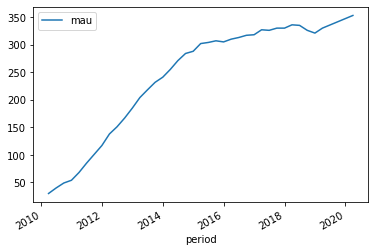

In [4]:
df.plot(x='period', y='mau')

In [5]:
import matplotlib.dates as mdates


degree = 3
y = np.array(df1['mau'].to_list())
X = np.array(mdates.date2num(df1['period']))
date_index = []
idx = 0
for i in X:
    date_index.append(idx)
    idx += 1

z = np.polyfit(date_index, y, degree)
f = np.poly1d(z)

df_trend = pd.DataFrame(columns=['X', 'y','d'])
df_trend['X'] = date_index
df_trend['y'] = y
df_trend['d'] = X


z = np.polyfit(df_trend.d, df_trend.y, degree)
model = np.poly1d(z)
results = smf.ols(formula='y ~ model(X)', data=df_trend).fit()

# results.summary()

In [19]:
X = mdates.date2num(df['period'])

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.xlabel('Time')
plt.ylabel('\# Users')
plt.plot(df1.period, df1.mau, color ='#339898', label = 'Monthly Acitive Users')
plt.plot(X, model(X), color ='#E31B23', linestyle ="--", label= '3rd Degree Polynomial Trend Line (R^2 = 0.885)')
plt.legend()
plt.savefig(os.path.join(path, 'MAU_trendline.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [ ]:
ax = plt.gca()
plt.xlabel('Time')
plt.ylabel('Users (Millions)')
plt.plot(df.period, df.mau, label='MAU', c = '#339898')
plt.plot(df.period, df.dau, c = '#E31B23', label = 'mDAU')

plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.savefig(os.path.join(path, 'twitter_users.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [ ]:
ax = plt.gca()
plt.xlabel('Time')
plt.ylabel('% Change')
plt.plot(df.period, df.mau_pct, label='MAU', c = '#339898')
plt.plot(df.period, df.dau_pct, c = '#E31B23', label = 'mDAU')

plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.savefig(os.path.join(path, 'twitter_users_pct.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [ ]:
ax = plt.gca()
plt.xlabel('Time')
plt.ylabel('% Change')
plt.plot(df.period, df.comb, label='Combined MAU/mDAU', c = 'black')

plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.savefig(os.path.join(path, 'twitter_comb_pct.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [ ]:
df = pd.read_csv('/Users/connormcdonald/Desktop/Masters/MIT807/Data/academic_results.csv')

In [ ]:
df['scopus_results'] = df['scopus_results']/1000000
df['scholar_results']  = df['scholar_results']/1000000

df['scopus_results_pct'] = 100*df['scopus_results'].pct_change()
df['scholar_results_pct'] = 100*df['scholar_results'].pct_change()

df.head()

,period,scholar_results,scopus_results,scopus_results_pct,scholar_results_pct
0,2010,4.51,2.478126,NaN,NaN
1,2011,4.59,2.638921,6.488572,1.773836
2,2012,4.67,2.775816,5.187537,1.742919
3,2013,4.36,2.901649,4.533190,-6.638116
4,2014,4.64,2.942515,1.408372,6.422018


In [ ]:
#first half plot
ax = plt.gca()
plt.xlabel('Time')
plt.ylabel('Results (Millions)')
plt.plot(df.period, df.scholar_results, label='Google Scholar', c = '#339898')
plt.plot(df.period, df.scopus_results, c = '#E31B23', label = 'Scopus')

plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.savefig(os.path.join(path, 'academic_search.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [ ]:
#first half plot
ax = plt.gca()
plt.xlabel('Time')
plt.ylabel('% Change')
plt.plot(df.period, df.scholar_results_pct, label='Google Scholar', c = '#339898')
plt.plot(df.period, df.scopus_results_pct, c = '#E31B23', label = 'Scopus')

plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.savefig(os.path.join(path, 'academic_search_pct.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [ ]:
df = pd.read_csv('/Users/connormcdonald/Desktop/Masters/MIT807/Data/dblp.csv')
df = df.set_index('period')

In [ ]:
df1 = df.iloc[:, 0:7]

In [ ]:
df2 = df.iloc[:, 4:8]
df2.head()

,journal articles,parts in books or collections,reference works,total
period,,,,
2010,83045,2916,1044,227707
2011,88188,2754,3177,248791
2012,94043,1991,274,261232
2013,99638,2957,128,278000
2014,105238,2855,2401,289383


In [ ]:
df2['total_pct'] = 100*df2['total'].pct_change()
df2['journal_pct'] = 100*df2['journal articles'].pct_change()

<ipython-input-33-d624d16b8be1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['total_pct'] = 100*df2['total'].pct_change()
<ipython-input-33-d624d16b8be1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['journal_pct'] = 100*df2['journal articles'].pct_change()


In [ ]:
# plot the pivoted dataframe
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
df1.plot.bar(stacked=True, figsize=(8, 4), ylabel='Number of Publications', xlabel='Year', cmap = 'rocket_r')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(path, 'computerscience_pub.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()

In [ ]:
#first half plot
ax = plt.gca()
plt.xlabel('Time')
plt.ylabel('% Change')
plt.plot(df2.index, df2.total_pct, c = '#339898', label='Total')
plt.plot(df2.index, df2.journal_pct, c = '#E31B23', label='Journals')
plt.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.savefig(os.path.join(path, 'computerscience_pub_pct.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()